<a href="https://colab.research.google.com/github/farukokumus/ML_EX/blob/main/exercise_1_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Exercise 1: PCA, ICA and Sparse Coding

**Note**: Please insert the names of all participating students:

1. FAZLI FARUK OKUMUS
2. MEVLÜDE TIGRE
3. 
4. 
5. 

## Preamble
The following code downloads and imports all necessary files and modules into the virtual machine of Colab. Please make sure to execute it before solving this exercise.

In [15]:
import sys, os
if 'google.colab' in sys.modules:
  if os.getcwd() == '/content':
    !git clone 'https://github.com/inb-uni-luebeck/cs5450.git'
    os.chdir('cs5450')

## Exercise 1.1: Applying unsupervised methods

In this exercise, we will apply three unsupervised methods, namely *Prinicipal Component Analysis (PCA)*, *Independent Component Analysis (ICA)*, and *Sparse Coding (SC)* to image patches taken from handwritting digits and from faces.

Since implementing [ICA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html) and [SC](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.SparseCoder.html) is rather complex, we will use already existing python packages.

We will build on the python starter code given below. You only need to write code at the places indicated by `TODO`.
The two given datasets are `mnist.npz` for handwritten digits and `olivetti.npz` for faces. Each dataset contains a multi dimensional array `data` with the first index corresponding to the observations and the second index corresponding to the features (grayscale pixels). Both datasets contain square-shaped images.

Implement the missing parts below. When done correctly, your code should do the following:
1. Load the dataset with either handwritten images or faces.
2. Enforce mean-free observations by subtracting the mean from the data.
3. Randomly draw square-shaped image patches from the data.
4. Apply one of the three unsupervised methods (PCA, ICA, or SC).
5. Show the resulting set of new basis vectors (i.e. the components for PCA and ICA).
6. Reconstruct the original image patches with different subsets of basis vectors.

Note that for sparse coding, the basis vectors are not ordered according to some metric (*unlike which method?*). To quickly reconstruct an image with only $i$ non-zero values, you should use the coefficients and basis vectors corresponding to the $i$ highest absolute coefficients (see [numpy.argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)). 

In case you are struggeling with the task, here are some helpful tips and hints:
1. Useful functions: [`numpy.load`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.load.html), [`ndarray.astype`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.astype.html), [`numpy.mean`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.mean.html), [`numpy.linalg.pinv`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.pinv.html), [`numpy.matmul`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.matmul.html), [`numpy.stack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.stack.html), `random_patches`, `show_in_grid`, [`PCA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), [`FastICA`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.FastICA.html#sklearn.decomposition.FastICA), [`DictionaryLearning`](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.DictionaryLearning.html#sklearn.decomposition.DictionaryLearning),[numpy.argsort](https://numpy.org/doc/stable/reference/generated/numpy.argsort.html)
2. You should start with both PCA and ICA and only then use SC.
3. Applying SC may take a couple of minutes. Good initial value for it are: 
 - `dataset='mnist'`
 - `n_patches=1000`
 - `patch_size=25`
 - `n_basis=100`
 - `n_iterations=50`
 - and instantiate the class with `n_jobs=-1` to utilize all CPU cores, as well as `verbose=True` to see progress feedback

Import and helper functions. Do not change!

In [16]:
import numpy as np
import math
import random
from sklearn.decomposition import PCA, FastICA, DictionaryLearning
from matplotlib import pyplot as plt
%matplotlib inline

def random_patches(data, img_height, img_width, n_patches, patch_size):
    # RANDOMPATCHES draw random square-shaped patches from the data.
    #
    # INPUT:
    #   data : ndarray containing the data (i.e. mnist or olivetti)
    #   img_height : height of the images
    #   img_width : width of the images
    #   n_patches : number of patches to be drawn
    #   patch_size : size (both width and height) of the square-shaped patches
    #
    # OUTPUT:
    #   patches : random patches

    # reshape data 2d -> 3d
    n_images = data.shape[0]
    data = data.reshape(n_images, img_height, img_width)

    # extract random patches
    patches = []#np.zeros((n_patches, patch_size*patch_size))
    for i in range(n_patches):
        patch_top = random.randint(0, img_height - patch_size)
        patch_left = random.randint(0, img_width - patch_size)
        p = data[random.randint(0, n_images-1), patch_top:patch_top+patch_size, patch_left:patch_left+patch_size]
        patches.append(p)
        #patches[i,:] = p[:]
        
    patches = np.stack(patches)
    patches = patches.reshape(patches.shape[0], -1) #flatten each patch
        
    return patches

def show_in_grid(images, height, width):
    # flatten images if necessary
    images = images.reshape(images.shape[0], -1)
    
    # normalize patches
    images = images / (np.abs(images).max(axis=1, keepdims=True)+1e-6)
    
    # reshape into images
    images = images.reshape(-1, height, width)
    
    # make images fit into a rectangular area
    grid_width = math.ceil(math.sqrt(images.shape[0]))
    grid_height = math.ceil(images.shape[0] / grid_width)
    
    empty_cells = grid_width * grid_height - images.shape[0]
    
    # fill empty cells
    if empty_cells > 0:
        padding = np.zeros((empty_cells, height, width))
        images = np.concatenate((images, padding))
        
    # rearrange basis into grid and also switch width and height so x and y axis are not switched
    images = images.reshape(grid_height, grid_width, height, width)
    images = images.transpose(0, 3, 1, 2)
    
    plt.figure(figsize = (10,10))
    plt.imshow(images.reshape(grid_height*height, grid_width*width), cmap='gray')
    plt.show()

Your solution:

In [17]:
## Define variables

# TODO dataset : relative path to the .npz file containing the data
dataset = '/content/cs5450/data/olivetti.npz' #'data/olivetti.npz'

# TODO n_patches : number of random patches to extract from the images
n_patches = 10000
# TODO patch_size : size (both width and height) of the square-shaped patches
patch_size = 55

# TODO n_basis : number of new basis vectors
n_basis = 100

# TODO method : string describing whether to perform pca, ica, or sc
method = 'pca'

# TODO n_iterations : number of iterations (only for sparse coding)
n_iterations = 50

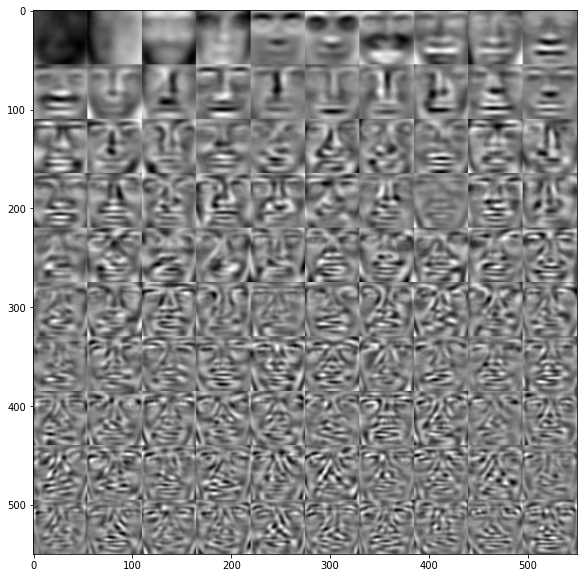

In [18]:
## Compute and show the principal components

# TODO load dataset
data=np.load(dataset)
#print(data)
data=data["data"]
# TODO convert data to floating point (double precision)
data=np.float64(data)
# print(data_float.shape)
# TODO get number of images (observations) and number of pixels (features)
n_images, n_pixels = data.shape[0], data.shape[1]
#print(n_pixels)
# TODO get height and width of the images
img_height = int(np.sqrt(n_pixels))
img_width = int(np.sqrt(n_pixels))
assert isinstance(img_height, int) and isinstance(img_width, int), "Image dimensions need to be integers."

# TODO enforce mean-free data vectors
mean_of_stuff = np.mean(data, axis=0)

mean_free_data = data - np.tile(mean_of_stuff, (n_images, 1)) # i could not grasp

# TODO draw random patches from data.
patches = random_patches(mean_free_data, img_height, img_width, n_patches, patch_size)

# TODO perform the chosen unsupervised method on the drawn patches
if method == 'pca':
    PCA = PCA(n_components=n_basis, copy=True, whiten=False)  # iterated_power = n_iterations
    patches_train = PCA.fit_transform(patches)
    basis = PCA.components_
elif method == 'ica':
    FastICA = FastICA(n_components=n_basis, whiten=True)
    patches_train = FastICA.fit_transform(patches)
    basis = FastICA.components_
elif method == 'sc':
    SC = DictionaryLearning(n_components=n_basis, n_jobs=-1, verbose=True, max_iter=n_iterations)
    patches_train = SC.fit_transform(patches)
    basis = SC.components_

# TODO show the new set of basis vectors (only the first n_basis)
show_in_grid(basis[:n_basis], patch_size, patch_size)

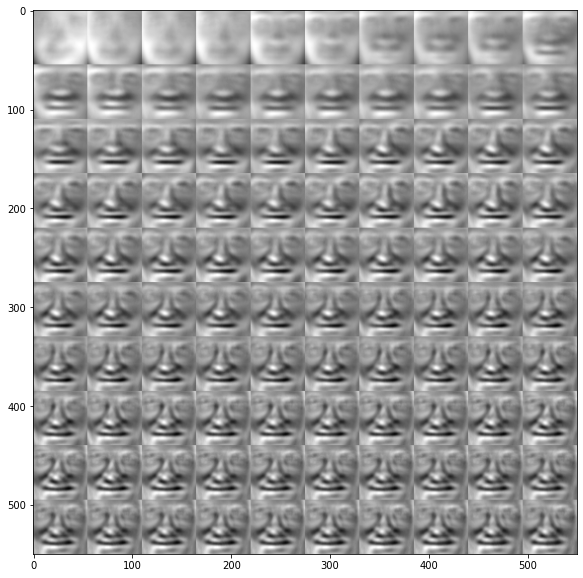

In [20]:
## Use different subsets of the new basis vectors to reconstruct a random patch
from sklearn.decomposition import sparse_encode

# TODO draw a random patch
random_patch = patches[np.random.randint(n_patches)] #random_patches(mean_free_data, img_height, img_width, n_patches, patch_size)

if method == 'sc':
    # TODO: pre-compute the inverse basis
    # TODO: pre-compute all coefficients
    # TODO: use argsort to find the indices with the highest absolute values
    inv_basis=np.linalg.pinv(basis)



# TODO reconstruct the random patch
reconstructions = []
for i in range(n_basis):
    sub_basis = basis[0:i+1]
    
    if method == 'sc':
        # only use the coefficients and basis vectors of the i highest 
        # absolute coefficients
        inv_sub_basis = np.linalg.pinv(sub_basis)
        random_patch = np.transpose(random_patch.reshape(-1, 1))
        se = sparse_encode(random_patch, sub_basis)
        single_reconstruction = np.dot(inv_sub_basis, np.transpose(se))
    else:
        single_reconstruction = np.dot(np.dot(np.linalg.pinv(sub_basis), sub_basis), random_patch)
    reconstructions.append(single_reconstruction)
reconstructions = np.stack(reconstructions)
# TODO show the reconstructed patch
show_in_grid(reconstructions, patch_size, patch_size)

*Bonus*: Implement the missing parts in the bonus section. When done correctly, your code additionally should do the following:
1. Perform ZCA whitening, whereas $\vec{x}_{ZCAwhite}=U\vec{x}_{wht}$ (c.f. equation 1.3 in the lecture notes).
2. Visualize the whitened data.

In [ ]:
#% TODO epsilon : avoid negative numbers while computing stdDeviations
epsilon = 0.1

# TODO perform principal component analysis (help pca)
basis = -1 #get basis vector components

# TODO compute the covariance matrix of the patches
covariance = -1

# TODO compute diagonal matrix S containing the standard deviations (c.f. page 6)
std_deviations = -1

# TODO pca whitening (c.f. equation 1.3)
xPCAwhite = -1

# TODO zca whitening
xZCAwhite = -1

# TODO visualize the whitened data
# show_in_grid(xZCAwhite[:n_basis], patch_size, patch_size)

## Exercise 1.2: Comprehension Questions

Answer the following comprehension questions either with *right* or *wrong* and briefly explain your decision:
1. Regardless of the used method for representation learning (i.e. PCA, ICA, SC), the resulting set of basis vectors depends on the given dataset.

Yes. The given dataset varies in terms of size and information given, so we can reduce different dimensions. The number of pixels from the patch depends concretely from the given dataset. In this case our datasets have different image sizes (28x28 and 64x64).

2. The first principal component has the smallest eigenvalue and covers the largest possible variance of the data.

No. The first principal component has the largest eigenvalue and covers the largest possible variance of the data.


3. The optimal number of principal components to retain is 42.

No, Because the number of principal component depends on us and how many component reduction we accepting.

4. After whitening, the features of an observation are uncorrelated and have unit variance.

Yes, The goal whitening itself is uncorrelate the data and normalize the variance to unity in principal directions.

5. The resulting basis vectors of the ICA (i.e. the independent components) are mutually orthogonal.

Basis vectors in ICA is independent oppositely in PCA which basis vectors are mutually orthogonal 

6. The ICA is an enhancement of the PCA which additionally makes the already uncorrelated features statistically independent.

Yes we can say that because ICA takes already whitened PCA data and makes it statistically independent.

7. The set of basis vectors of the ICA can be over-complete, i.e. more basis vectors than dimensions of the input space.

Yes this is possible for ICA

8. Sparsity means that only a few basis vectors are used to reconstruct an image.

Sparsity used few of the data vectors which are not equal to zero to reconstruct image, not uses  basis vectors.

9. The optimization problem for SC (c.f. equation 1.9 in the lecture notes) is convex.

Optimization of SC means minimization, then this is convex. The aim of a convex optimisation is to minimize

10. Unlike PCA and ICA, SC results in a linear transform of the data.

No, Sc is not a linear.